In [3]:
import numpy as np
from numpy import cos, sin, pi, sqrt, arctan2
import matplotlib.pyplot as plt
import healpy as hp
from healpy.newvisufunc import projview, newprojplot

plt.rcParams['figure.dpi'] = 200
REarth = 6.371 * 1e6 #m
c = 3*1e8
%load_ext autoreload
%autoreload 2

In [4]:


# vector basis

def u_v_Omega_basis(theta, phi):
    u = np.array([np.cos(theta)*np.cos(phi), np.cos(theta)*sin(phi), -np.sin(theta)])
    v = np.array([-np.sin(phi), np.cos(phi), 0])
    Omega = np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
    return u, v, Omega

def Omega(theta, phi):
    return u_v_Omega_basis(theta, phi)[2]#np.array([sin(theta),0., cos(theta) ])

def m_n_Omega_basis(theta, phi, psi):
    u, v, Omega = u_v_Omega_basis(theta, phi)
    m = u*np.cos(psi) + v*np.sin(psi)
    n = -u*np.sin(psi) + v*np.cos(psi)
    return m, n, Omega

def rotate(x, beta):
    return np.array([x[0]*cos(beta) + x[1]*sin(beta), -x[0]*sin(beta) + x[1]*cos(beta), x[2]])

def e_pol(theta, phi, psi): #polarization tensors    
    m, n, Omega = m_n_Omega_basis(theta, phi, psi)
    e_plus = np.outer(m, m) - np.outer(n, n)
    e_cross = np.outer(m, n) + np.outer(n, m)
    e_x = np.outer(m, Omega) + np.outer(Omega, m)
    e_y = np.outer(n, Omega) + np.outer(Omega, n)
    e_b = np.outer(m,m) + np.outer(n,n)
    e_l = sqrt(2)*(np.outer(Omega, Omega))
    return e_plus, e_cross, e_x, e_y, e_b, e_l

def T_pta_normal(L, f, theta, phi, psi):
    x = f*L/c
    return x, (c/L)*( 1/(1j*2*pi*f) * (1 - np.exp(-1j*2*pi*f* (1)*L/c)) )

def T_pta(L, f, theta, phi, psi, u):
    Omega = m_n_Omega_basis(theta, phi, psi)[2]
    return ( 1/(1j*2*pi*f*(1- np.dot(u, Omega))) * (1 - np.exp(-1j*2*pi*f* ((1- np.dot(u, Omega))*L/c)) ))

def D(Omega, p):
    D = np.zeros((len(p), len(p)), float)
    for i in range(len(p)):
        for j in range(len(p)):
            D[i,j] = p[i]* p[j]/ (2*(1+np.dot(p, Omega)))
    return D

def F_pulsar(theta, phi, psi, e1): #angular pattern function in the non small antenna limit (WIP)
    e_plus, e_cross, e_x, e_y, e_b, e_l = e_pol(theta, phi, psi)
    Omega = m_n_Omega_basis(theta, phi, psi)[2]
    F_plus = 0
    F_cross = 0
    F_x = 0
    F_y = 0
    F_b = 0
    F_l = 0
    for i in range(len(e1)):
        for j in range(len(e1)):
            F_plus += e_plus[i, j]*D(Omega, e1)[i, j]
            F_cross += e_cross[i, j]*D(Omega, e1)[i, j]
            F_x += e_x[i, j]*D(Omega, e1)[i, j]
            F_y += e_y[i, j]*D(Omega, e1)[i, j]
            F_b += e_b[i, j]*D(Omega, e1)[i, j]
            F_l += e_l[i, j]*D(Omega, e1)[i, j]
    return F_plus, F_cross, F_x, F_y, F_b, F_l

def gamma_pq(theta, phi, psi, p, q):
    Fp = F_pulsar(theta, phi, psi, p)
    Fq = F_pulsar(theta, phi, psi, q)
    return 4*(Fp[0]*Fq[0] + Fp[1]*Fq[1])


def gamm_pq_all(theta, phi, psi, cat):
    sum = 0
    N = len(cat[0,:])
    for i in range(N):
        for j in range(i+1, N):
            sum +=gamma_pq(theta, phi, psi, cat[:,i], cat[:,j])
    return sum

def F_pulsar_transfer(theta, phi, psi, u, L, c, f): #angular pattern function in the non small antenna limit (WIP)
    F_plus, F_cross = F_pulsar(theta, phi, psi, u)
    tr = T_pta(L, f, theta, phi, psi, u)
    return F_plus*tr, F_cross*tr


# PTA 

def HellingsDowns(catalogue1, catalogue2):
    alpha = np.arccos(np.dot(catalogue1, catalogue2)/ (np.linalg.norm(catalogue1) * np.linalg.norm(catalogue2)))
    arg = (1-np.cos(alpha))/2
    return (3/2)*arg*np.log(arg) - arg/4 + 0.5

def orf_pta_single(catalogue1, catalogue2, f):
    return HellingsDowns(catalogue1, catalogue2)/((2*np.pi*f)**2 *3)

def orf_pta(catalogue, f): # for a network of pulsar
    orf =  0
    for i in range(len(catalogue)):
        for j in range(i+1, len(catalogue)):
            orf += orf_pta_single(catalogue[i], catalogue[j], f)
    return orf
    


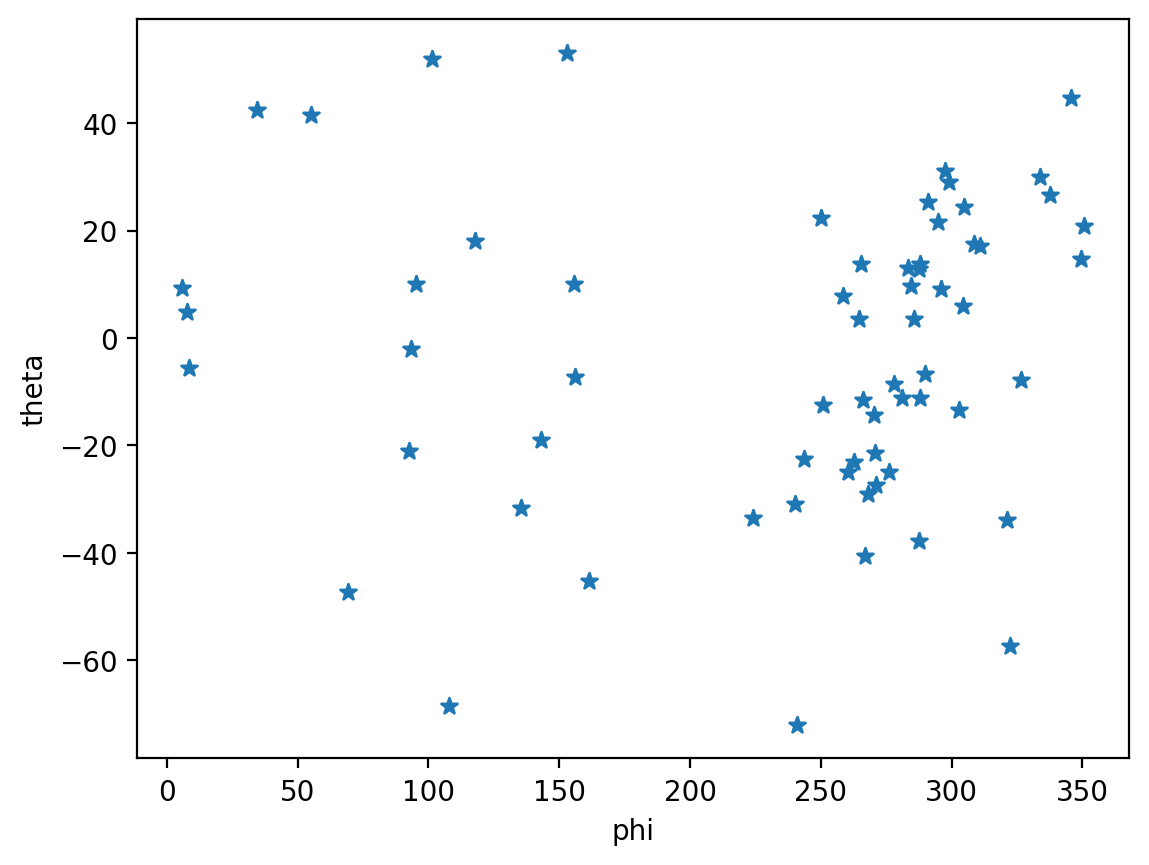

[-2.49600929e+15 -2.27427070e+15 -2.07223076e+15 -1.88813949e+15
 -1.72040238e+15 -1.56756658e+15 -1.42830828e+15 -1.30142131e+15
 -1.18580663e+15 -1.08046284e+15 -9.84477497e+14 -8.97019229e+14
 -8.17330513e+14 -7.44721123e+14 -6.78562151e+14 -6.18280560e+14
 -5.63354219e+14 -5.13307383e+14 -4.67706570e+14 -4.26156807e+14
 -3.88298211e+14 -3.53802868e+14 -3.22371996e+14 -2.93733357e+14
 -2.67638895e+14 -2.43862593e+14 -2.22198512e+14 -2.02459009e+14
 -1.84473109e+14 -1.68085026e+14 -1.53152816e+14 -1.39547142e+14
 -1.27150158e+14 -1.15854489e+14 -1.05562295e+14 -9.61844317e+13
 -8.76396719e+13 -7.98540050e+13 -7.27599953e+13 -6.62961978e+13
 -6.04066263e+13 -5.50402681e+13 -5.01506424e+13 -4.56953976e+13
 -4.16359444e+13 -3.79371218e+13 -3.45668925e+13 -3.14960650e+13
 -2.86980414e+13 -2.61485865e+13 -2.38256182e+13 -2.17090159e+13
 -1.97804468e+13 -1.80232064e+13 -1.64220744e+13 -1.49631826e+13
 -1.36338947e+13 -1.24226971e+13 -1.13190989e+13 -1.03135413e+13
 -9.39731475e+12 -8.56248

In [7]:
#get the pulsar position from the catalogue
theta0, phi0 = np.loadtxt('pulsar_cat.txt', unpack=True)


plt.scatter(np.array(phi0), np.array(theta0), marker='*')
plt.xlabel('phi')
plt.ylabel('theta')
plt.show()

theta = np.deg2rad(90 + theta0) #it has to be defined between 0 and pi
phi = np.deg2rad(phi0)#np.deg2rad(phi0) #-180 #np.deg2rad(phi)

pulsars_cat = np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])

catalogue = pulsars_cat 

f = np.logspace(-9, -7, 100)

overlap_pta = orf_pta(catalogue, f)
print(overlap_pta)

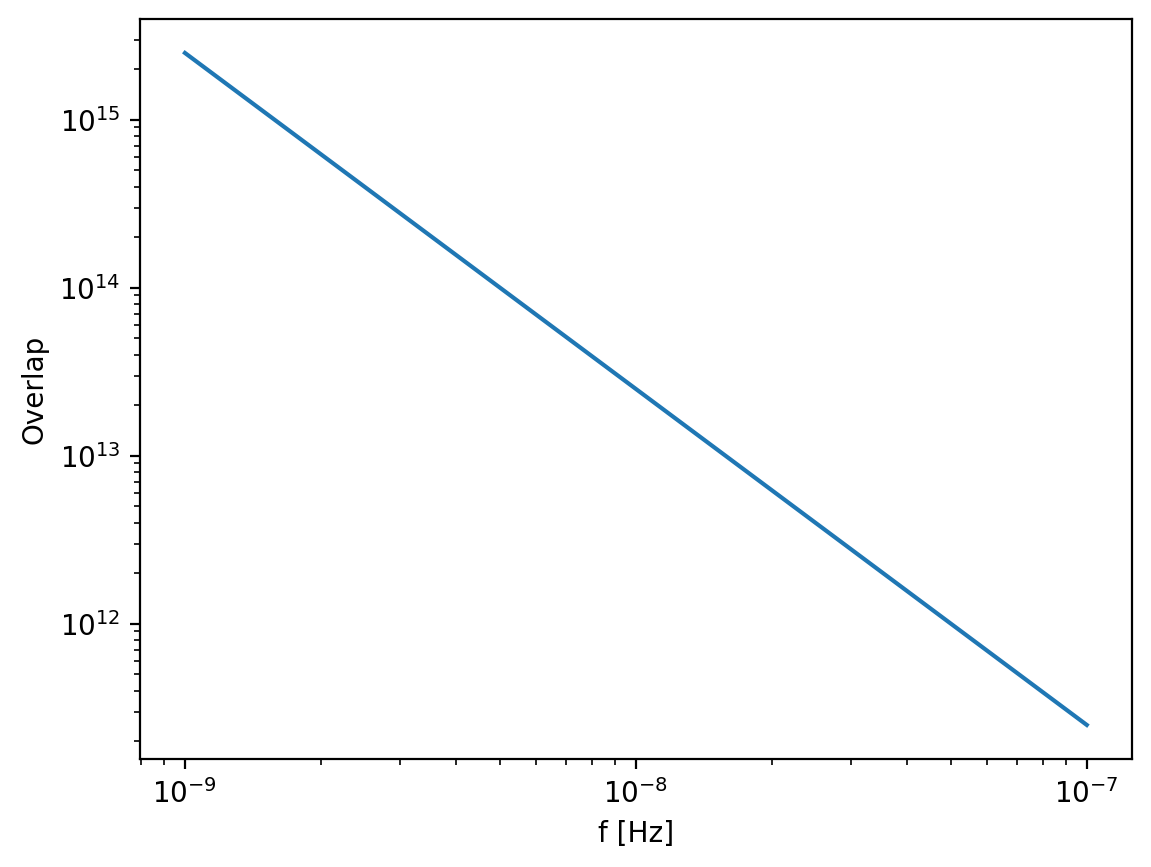

In [8]:
plt.loglog(f, np.abs(overlap_pta), label='PTA')
plt.xlabel('f [Hz]')
plt.ylabel('Overlap')
plt.show()


In [9]:
from astropy.cosmology import Planck15

cosmo = Planck15
H0 =  cosmo.H0.to('1/s').value

In [10]:
f, om = np.genfromtxt('Omegaeff.txt', unpack=True)

In [12]:
def PTA_Pn():
    DT_inverse = 20/(365*24*3600) #Hz
    s = 100 * 1e-9 #s
    return 2* (s**2)/DT_inverse


def PTA_Sn(f):
    f = np.asarray(f) # Ensure f is a NumPy array
    mask = f >= 8e-9 # Create a boolean mask where True indicates elements greater than or equal to 8e-9
    return np.where(mask, PTA_Pn() * 12 * (np.pi**2) * f**2, 1) # Apply the mask to the result

def PTA_Seff(f, catalogue):
    hd = 0
    for i in range(len(catalogue)):
        for j in range(i+1, len(catalogue)):
            hd += (HellingsDowns(catalogue[i], catalogue[j]))**2
    return hd*PTA_Sn(f)

def PTA_Omegaeff(f, catalogue, om_load):
    if om_load==False:
        return 10 * np.pi * np.pi * f**3 * PTA_Seff(f, catalogue) / (3* (H0**2))
    else:
        return np.genfromtxt('/Users/ic/Desktop/GWBird/pulsar_catalog.txt', unpack=True, usecols=1)

def Omega_beta_PTA(f_range, snr, Tobs, beta, catalogue, om_load):
    Tobs = Tobs*365*24*3600
    fref = 1e-8
    integrand = lambda f : ((f/fref)**(2*beta))/ (PTA_Omegaeff(f, catalogue, om_load)**2)
    integral = np.trapz(integrand(f_range), f_range)
    return snr / np.sqrt(2*Tobs*integral)

def Omega_GW_PTA(f_i,  beta, fref, snr, Tobs, catalogue, om_load):
    return Omega_beta_PTA(f_i, snr, Tobs, beta, catalogue, om_load) * ((f_i/fref)**(beta))

def all_Omega_GW_PTA(f_i, snr, Tobs, beta_min, beta_max, catalogue, om_load):
    beta = np.linspace(beta_min, beta_max, 100)
    fref = 1e-8
    Omega = np.zeros((len(beta), len(f_i)))
    for i, beta_val in enumerate(beta):
        Omega[i, :] = Omega_GW_PTA(f_i, beta_val, fref, snr, Tobs, catalogue, om_load)
    return beta, Omega

def find_pls_PTA(f_i, snr, Tobs, beta_min, beta_max, catalogue, om_load):

    beta, Omega = all_Omega_GW_PTA(f_i, snr, Tobs, beta_min, beta_max, catalogue, om_load)
    pls = np.max(Omega, axis=0)
    return pls

In [13]:
pta_pls = find_pls_PTA(f, 1, 5, -8., 8., catalogue, om_load=False)
pta_sn =  2 * np.pi * np.pi *( f**3) * PTA_Sn(f) / (3* H0 * H0)

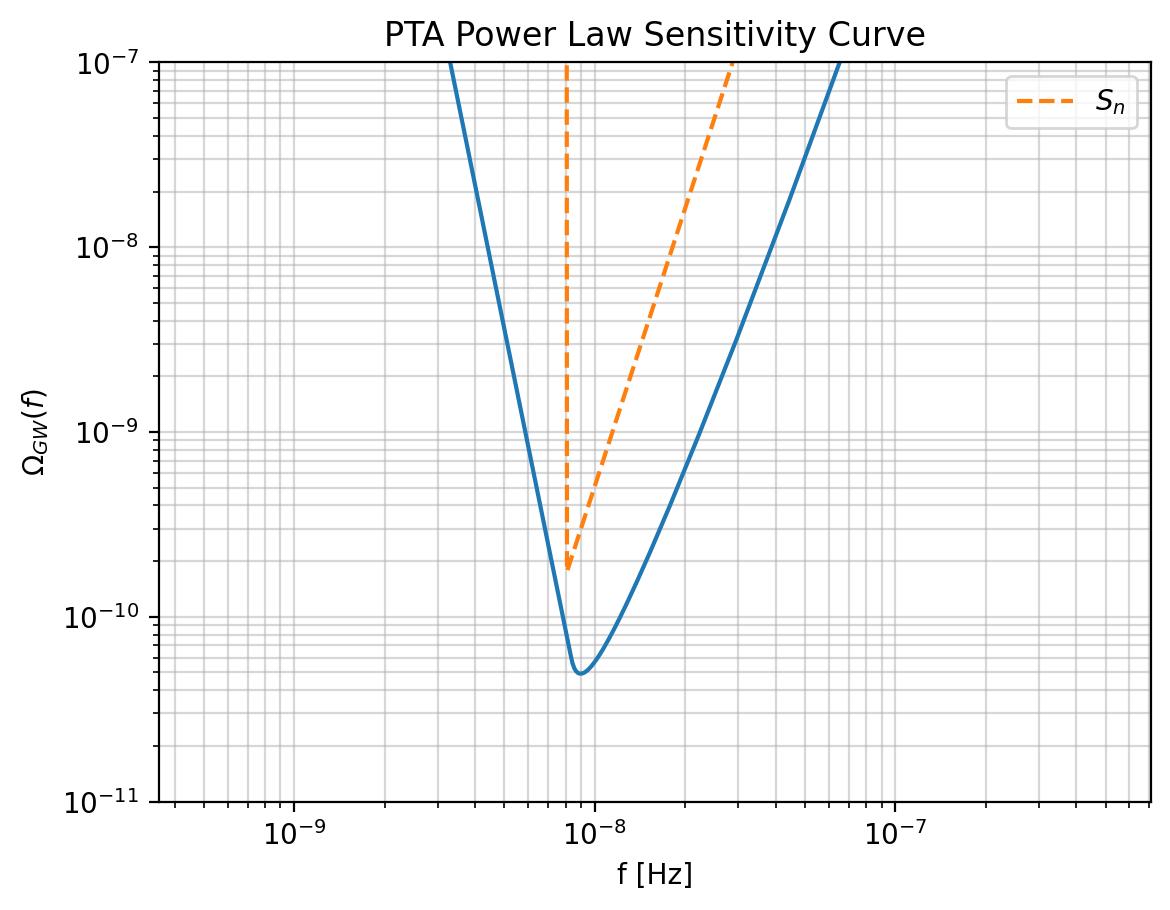

In [14]:
plt.loglog(f, pta_pls)
plt.loglog(f, pta_sn , linestyle='--', label='$S_n$')
plt.xlabel('f [Hz]')
plt.ylabel('$\Omega_{GW}(f)$')
plt.ylim(1e-11, 1e-7)
plt.grid(which='both', alpha = 0.5)
plt.title('PTA Power Law Sensitivity Curve')
plt.legend()
plt.show()


C_l decomposition of a skymap

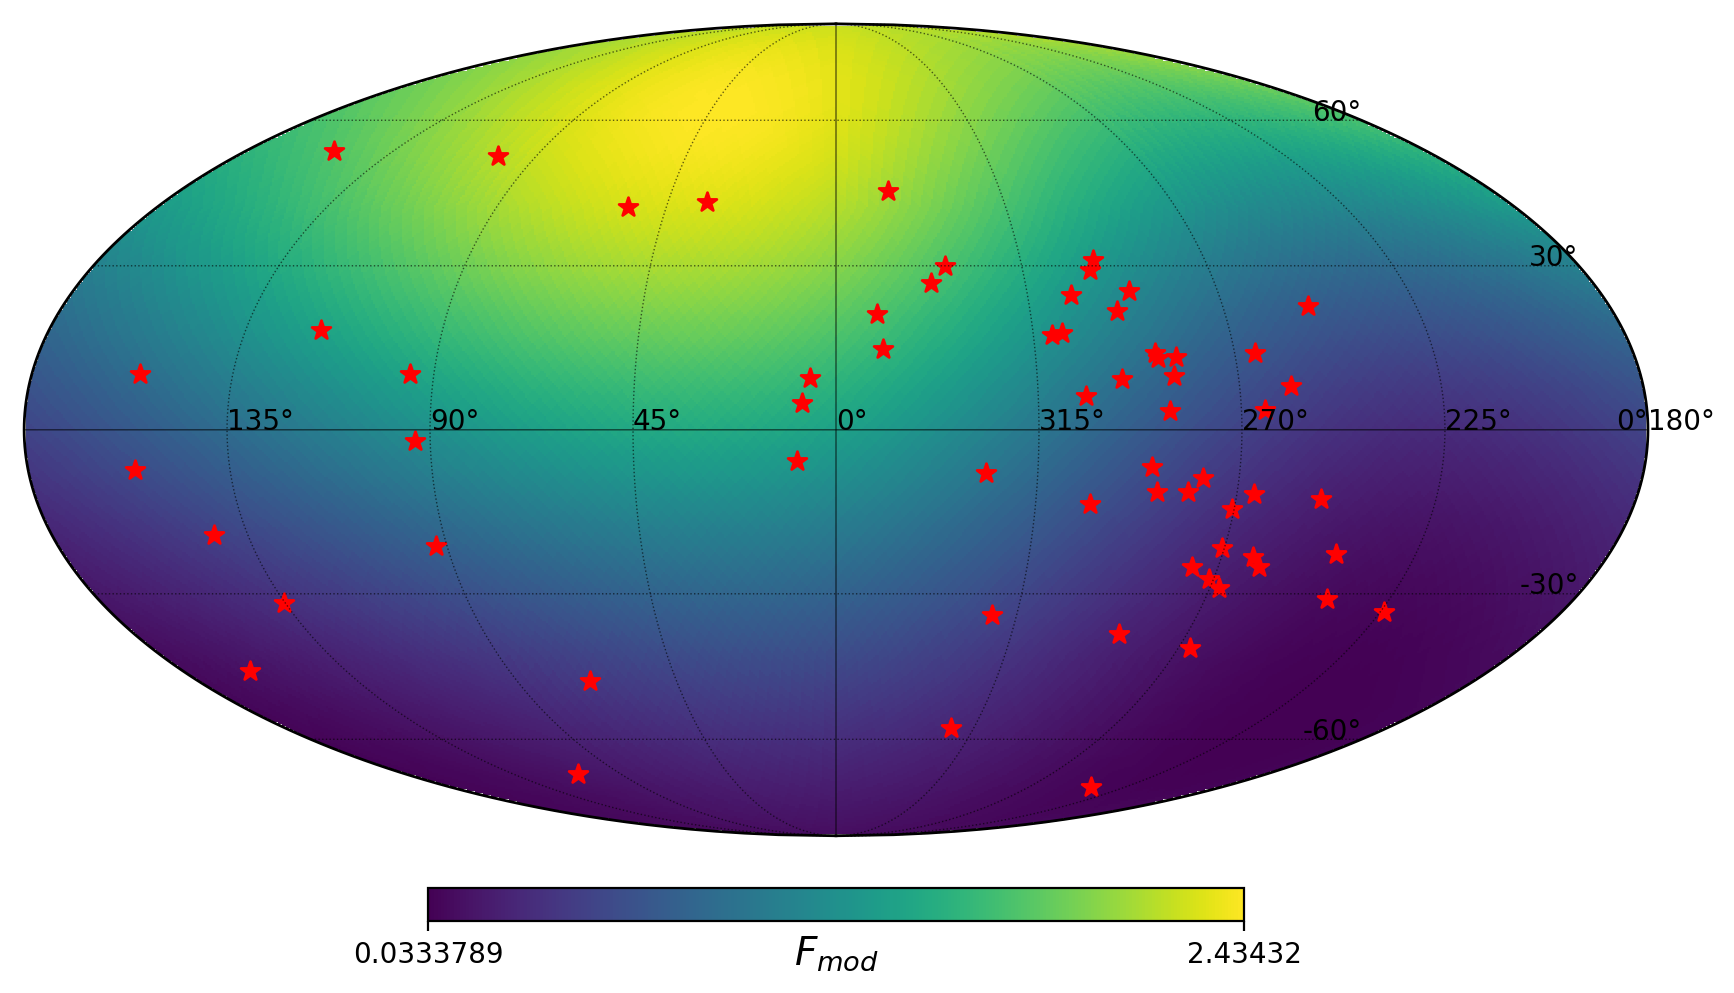

64


In [8]:
nside = 32
npix = hp.nside2npix(nside)
theta_i, phi_i = hp.pix2ang(nside, np.arange(npix))
L = 1e19 # 1kpc in m, distance from a pulsar
c = 3e8 # m/s
f_i = 1e-8 # Hz

apf = np.zeros(len(theta_i), float)

for ii in range(len(theta_i)):
    for i in range(len(pulsars_cat[:,0])):
        #apf[ii] += (F_pulsar_transfer(theta_i[ii], phi_i[ii], 0, pulsars_cat[:,i], L, c, f_i)[0]**2) + (F_pulsar_transfer(theta_i[ii], phi_i[ii], 0, pulsars_cat[:,i],L, c, f_i)[1]**2)
        apf[ii] += (F_pulsar(theta_i[ii], phi_i[ii], 0, pulsars_cat[:,i])[0]**2) + (F_pulsar(theta_i[ii], phi_i[ii], 0, pulsars_cat[:,i])[1]**2)

map = apf 

rotator = hp.Rotator(coord=['G','C']) # Change to your current and desired coordinate systems
rot_map = rotator.rotate_map_pixel(map) 

hp.mollview(rot_map, 
            #flip="geo",  # First Light Projected
            coord=["E"],
            notext=True,
            title="",
            unit="$F_{mod}$",  # You can put the unit of your map data here
            norm=None)  # Label for the colorbar)  # Ensure colorbar is shown


hp.graticule(dpar=30, dmer=45, coord=["E"], color="k", alpha=0.6, lw=0.5)


for lon in range(0, 360, 45):
    hp.projtext(lon, 0, "{}°".format(lon), lonlat=True, coord=["E"])
for lat in range(-60, 90, 30):
    hp.projtext(180, lat, "{}°".format(lat), lonlat=True, coord=["E"], ha="right")

for i in range(len(pulsars_cat[0, :])):
    hp.projscatter(phi0[i], theta0[i], lonlat=True, marker='*', color='red', s=50)


plt.show()

print(len(phi))

[[ 6.12323400e-17 -1.83697020e-16 -7.07106781e-01 -1.00000000e+00
  -7.07106781e-01]
 [ 1.00000000e+00 -1.00000000e+00  8.65956056e-17  1.22464680e-16
   8.65956056e-17]
 [ 6.12323400e-17  6.12323400e-17 -7.07106781e-01  6.12323400e-17
   7.07106781e-01]]


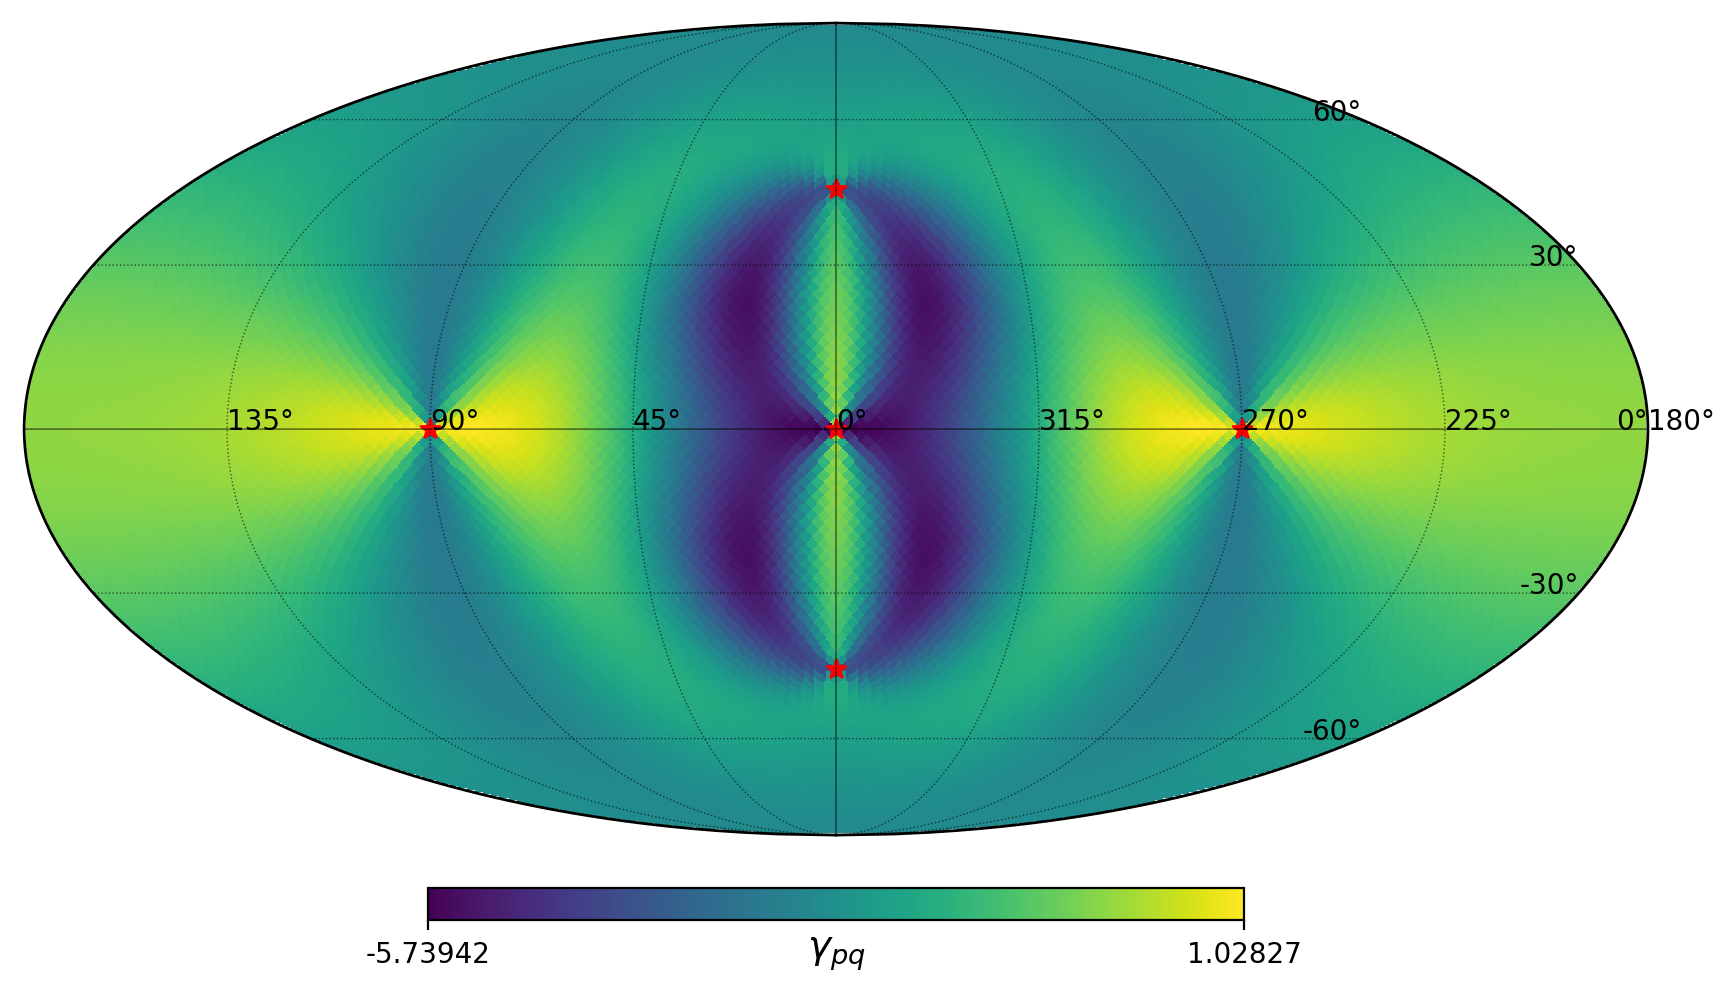

In [11]:
theta20 = np.array([0, 0,  np.pi/4, 0, -np.pi/4])
phi20 = np.array([-np.pi/2., np.pi/2, 0, 0, 0])

theta2_hp = (np.pi/2) + theta20
phi2 = phi20 + np.pi


# Now calculate the Cartesian coordinates
pulsars_cat2 = np.array([np.sin(theta2_hp)*np.cos(phi2), 
                         np.sin(theta2_hp)*np.sin(phi2), 
                         np.cos(theta2_hp)])

print(pulsars_cat2)

nside2 = 32
npix2 = hp.nside2npix(nside2)
theta2_i, phi2_i = hp.pix2ang(nside2, np.arange(npix2))


apf2 = np.zeros(len(theta2_i), float)

for i in range(len(theta2_i)):
    #apf2[i] = overlap.gamma_pq(theta2_i[i], phi2_i[i], 0, pulsars_cat2[:,0], pulsars_cat2[:,1])
    apf2[i] = overlap.gamm_pq_all(theta2_i[i], phi2_i[i], 0, pulsars_cat2)

map2 = apf2

rotator = hp.Rotator(coord=['G','C']) # Change to your current and desired coordinate systems
rot_map2 = rotator.rotate_map_pixel(map2)

hp.mollview(map2, 
            #flip="geo",  # First Light Projected
            coord=["E"],
            notext=True,
            title="",
            unit="$\gamma_{pq}$",  # You can put the unit of your map data here
            norm=None)  # Label for the colorbar)  # Ensure colorbar is shown


hp.graticule(dpar=30, dmer=45, coord=["E"], color="k", alpha=0.6, lw=0.5)


for lon in range(0, 360, 45):
    hp.projtext(lon, 0, "{}°".format(lon), lonlat=True, coord=["E"])
for lat in range(-60, 90, 30):
    hp.projtext(180, lat, "{}°".format(lat), lonlat=True, coord=["E"], ha="right")

hp.projscatter(np.rad2deg(phi20), np.rad2deg(theta20), lonlat=True, marker='*', color='red', s=50)


Overlap Reduction function for a set of pulsars

In [12]:
gamma = np.zeros(len(theta_i), float)

for ii in range(len(theta_i)):
    gamma[ii] = overlap.gamm_pq_all(theta_i[ii], phi_i[ii], 0, pulsars_cat)



rotator = hp.Rotator(coord=['G','C']) # Change to your current and desired coordinate systems
gamma_r = rotator.rotate_map_pixel(gamma) 

hp.mollview(gamma_r, 
            #flip="geo",  # First Light Projected
            coord=["E"],
            notext=True,
            title="",
            unit="$F_{mod}$",  # You can put the unit of your map data here
            norm=None)  # Label for the colorbar)  # Ensure colorbar is shown


hp.graticule(dpar=30, dmer=45, coord=["E"], color="k", alpha=0.6, lw=0.5)


for lon in range(0, 360, 45):
    hp.projtext(lon, 0, "{}°".format(lon), lonlat=True, coord=["E"])
for lat in range(-60, 90, 30):
    hp.projtext(180, lat, "{}°".format(lat), lonlat=True, coord=["E"], ha="right")

for i in range(len(pulsars_cat[0, :])):
    hp.projscatter(phi0[i], theta0[i], lonlat=True, marker='*', color='red', s=50)


plt.show()

print(len(phi))

[1.25663698e+01 2.53162656e+00 6.79091214e-02 9.54311976e-15
 1.24800098e-14 9.54105568e-15 1.25734354e-14 9.61616233e-15
 1.26537096e-14 9.62388349e-15 1.25942985e-14 9.58589973e-15
 1.25747006e-14 9.61431125e-15 1.26707668e-14 9.67660449e-15
 1.27178791e-14 9.68077306e-15 1.26800653e-14 9.67037738e-15
 1.27115797e-14 9.72137812e-15 1.28142894e-14 9.78095843e-15
 1.28457750e-14 9.78761896e-15 1.28341612e-14 9.80241788e-15
 1.29080597e-14 9.87297954e-15 1.30137242e-14 9.93228690e-15
 1.30395353e-14 9.94688367e-15 1.30623848e-14 9.98899365e-15
 1.31747134e-14 1.00784069e-14 1.32819098e-14 1.01406777e-14
 1.33145798e-14 1.01712216e-14 1.33834370e-14 1.02466052e-14
 1.35345170e-14 1.03579831e-14 1.36486497e-14 1.04311920e-14
 1.37085005e-14 1.04918158e-14 1.38415437e-14]
[9.54311976e-15 1.24800098e-14 9.54105568e-15 1.25734354e-14
 9.61616233e-15 1.26537096e-14 9.62388349e-15 1.25942985e-14
 9.58589973e-15 1.25747006e-14 9.61431125e-15 1.26707668e-14
 9.67660449e-15 1.27178791e-14 9.68077

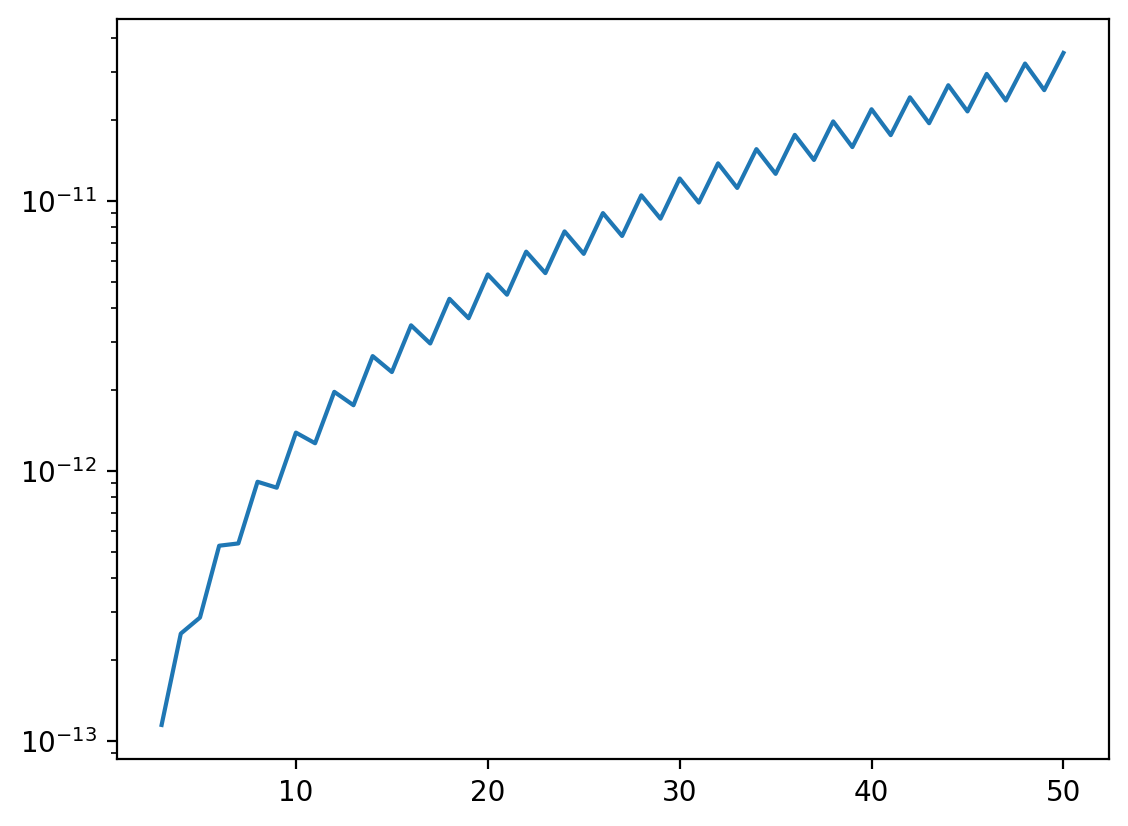

In [ ]:
Cl = hp.anafast(map, lmax=50)
print(Cl)
#drop monopole
Cl = Cl[3:]
print(Cl)

# Build an array of ell starting from l = 2
ell = np.arange(3, len(Cl) + 3)


plt.plot(ell, ell*(ell+1)*Cl)
plt.yscale('log')

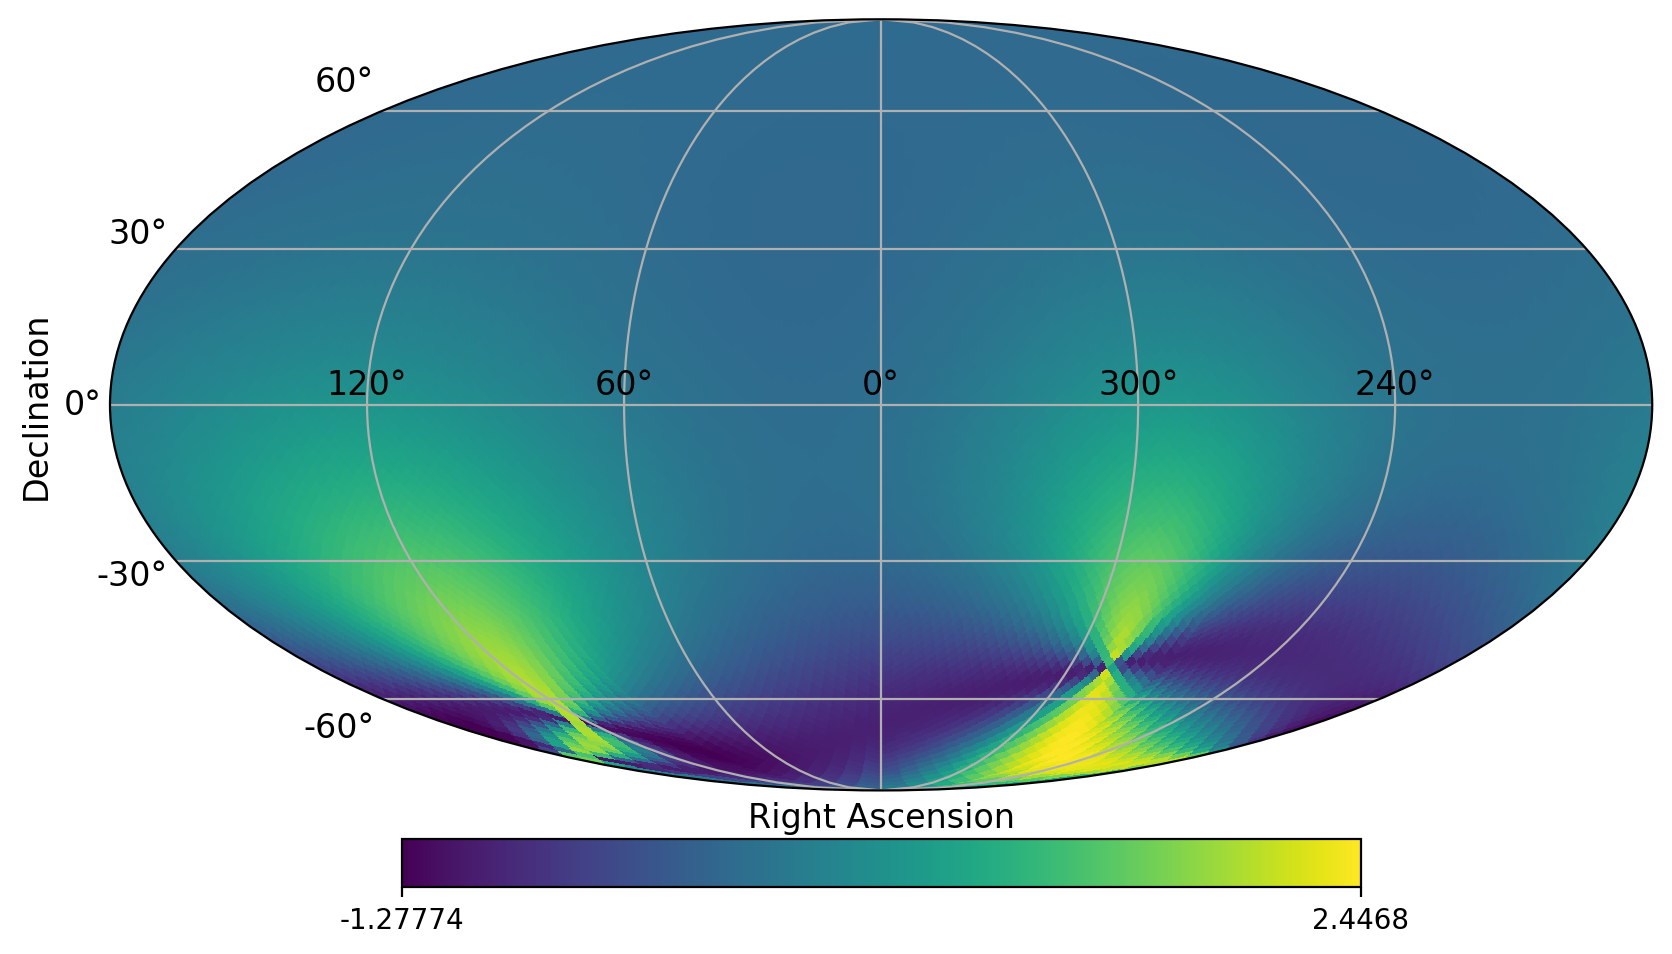

In [ ]:
orf = np.zeros(len(theta_i), float)


for ii in range(len(theta_i)):
    for i in range(len(pulsars_cat[:,0])):
        for j in range(i+1, len(pulsars_cat[:,0])):
            orf[ii] += (F_pulsar(theta_i[ii], phi_i[ii], 0, pulsars_cat[:,i])[0] * F_pulsar(theta_i[ii], phi_i[ii], 0, pulsars_cat[:,j])[0]) + (F_pulsar(theta_i[ii], phi_i[ii], 0, pulsars_cat[:,i])[1] * F_pulsar(theta_i[ii], phi_i[ii], 0, pulsars_cat[:,j])[1])


hp.projview(
    orf,
    coord=["C"],
    flip="astro",
    graticule=True,
    graticule_labels=True,
    xlabel="Right Ascension",
    ylabel="Declination",
    #title="Mollweide Projection"
)

for i in range(len(pulsars_cat[0,:])):
    hp.projplot(np.rad2deg(phi[i]),np.rad2deg(theta[i]- pi/2),  lonlat=True, marker='*', color='red')


[5.24627112e-01 3.79334227e-02 1.88739452e-01 7.67777708e-02
 2.57060807e-02 2.78329493e-02 2.69149927e-02 1.91126323e-02
 1.05016908e-02 4.86033110e-03 2.37021781e-03 1.59267939e-03
 1.27433055e-03 9.53364374e-04 6.84549585e-04 5.78715960e-04
 5.91956695e-04 5.92040446e-04 5.03018557e-04 3.58999394e-04
 2.44690750e-04 2.08234069e-04 2.28183342e-04 2.47289396e-04
 2.26725819e-04 1.70943330e-04 1.11846210e-04 7.61150105e-05
 6.67473061e-05 6.85461069e-05 6.58825259e-05 5.45661421e-05
 4.04199600e-05 3.03621563e-05 2.60201494e-05 2.44235148e-05
 2.25831442e-05 2.03559807e-05 1.93308098e-05 2.00799252e-05
 2.10677968e-05 2.02545185e-05 1.72381040e-05 1.37168759e-05
 1.18069582e-05 1.20947558e-05 1.32271790e-05 1.32923504e-05
 1.15186722e-05 8.75851488e-06 6.53969750e-06]
[7.67777708e-02 2.57060807e-02 2.78329493e-02 2.69149927e-02
 1.91126323e-02 1.05016908e-02 4.86033110e-03 2.37021781e-03
 1.59267939e-03 1.27433055e-03 9.53364374e-04 6.84549585e-04
 5.78715960e-04 5.91956695e-04 5.92040

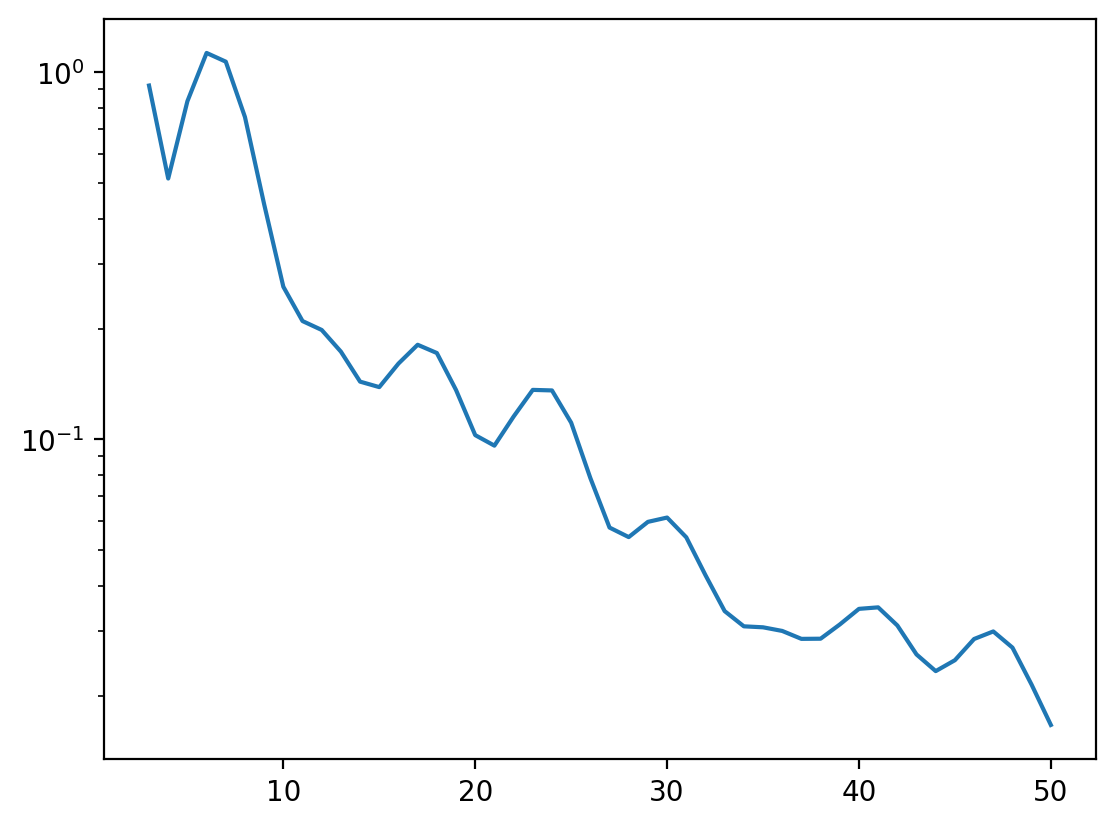

In [ ]:
Cl = hp.anafast(orf, lmax=50)
print(Cl)
#drop monopole
Cl = Cl[3:]
print(Cl)

# Build an array of ell starting from l = 2
ell = np.arange(3, len(Cl) + 3)


plt.plot(ell, ell*(ell+1)*Cl)
plt.yscale('log')